# Customer Churn - Feature Engineering

Let's implement some feature engineering to enhance model training.

In [60]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from scipy import stats


In [61]:
# configure visuals
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Current State of the data

In [62]:
# take a look at our data
df = pd.read_csv('data/processed/customer_churn_clean.csv')
print("\nDataset shape:", df.shape)
df.head()



Dataset shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-vhveg,female,0,1,0,1,0,0,dsl,0,1,0,0,0,0,month-to-month,1,electronic check,29.850,29.850,0
1,5575-gnvde,male,0,0,0,34,1,0,dsl,1,0,1,0,0,0,one year,0,mailed check,56.950,1889.500,0
2,3668-qpybk,male,0,0,0,2,1,0,dsl,1,1,0,0,0,0,month-to-month,1,mailed check,53.850,108.150,1
3,7795-cfocw,male,0,0,0,45,0,0,dsl,1,0,1,1,0,0,one year,0,bank transfer (automatic),42.300,1840.750,0
4,9237-hqitu,female,0,0,0,2,1,0,fiber optic,0,0,0,0,0,0,month-to-month,1,electronic check,70.700,151.650,1


In [63]:
# drop customer id column as it doesn't provide and valuable information
df.drop(columns='customerID', inplace=True)

# One-Hot Encoding

One-hot encoding can help translate categorical values into a set of indicator values in which the model can use to identity more complex relationships between features

let's take a look at some of the features in which we can apply one-hot encoding:
* gender
* InternetService
* Contract
* PaymentMethod

In [64]:
# since our gender feature contains two genders (male and female), we can one-hot encode only only of the genders.
# say we one-hot encode female, we would get 1 and 0. 1 would indicate female and 0 would indicate male.
# this would allow use to apply one-hot encoding while also not increasing our parameter size

encoder = OneHotEncoder()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
print(categorical_cols)

# encode with OneHotEncoder from sklearn
encoder = OneHotEncoder(sparse_output=False)
one_hot_encoded = encoder.fit_transform(df[categorical_cols])
one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_cols))

# drop one of the gender columns
one_hot_df.drop(columns='gender_male', inplace=True)

# add columns to previous df
df_new = pd.concat([df, one_hot_df], axis=1)

# drop the old categorical columns
df_new = df_new.drop(categorical_cols, axis=1)

# check my work
df_new.head()
df_new.info()

['gender', 'InternetService', 'Contract', 'PaymentMethod']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 27 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   SeniorCitizen                            7043 non-null   int64  
 1   Partner                                  7043 non-null   int64  
 2   Dependents                               7043 non-null   int64  
 3   tenure                                   7043 non-null   int64  
 4   PhoneService                             7043 non-null   int64  
 5   MultipleLines                            7043 non-null   int64  
 6   OnlineSecurity                           7043 non-null   int64  
 7   OnlineBackup                             7043 non-null   int64  
 8   DeviceProtection                         7043 non-null   int64  
 9   TechSupport                              7043 non-null   in

# Binning

During the EDA process, we were able to identify an opportunity to continuous, numerical data into categorical features. 

Let's revisit the histogram of the **MonthlyCharges** feature:

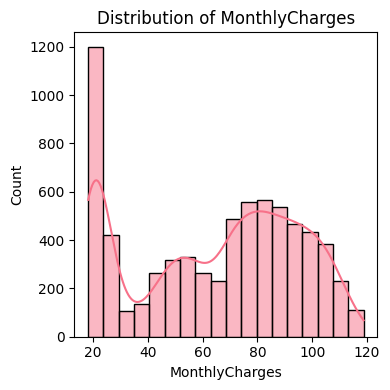

In [65]:
plt.figure(figsize=(4,4))
sns.histplot(data=df_new,x=df_new['MonthlyCharges'],kde=True).set_title("Distribution of MonthlyCharges")
plt.tight_layout()
plt.show()

From the histogram, we can see three clear peaks:
* First peak is between 0 - 30 
* Second peak between 31 - 70
* Third peak between 71 - 100

In [66]:
# define our bins
bins = [0, 30, 70, 100]

"""
    mapping our labels to numeric values
    1 - Basic
    2 - Mid-Tier
    3 - Premium
"""
bin_labels = [1, 2, 3]

df_new['PackageTier'] = pd.cut(df['MonthlyCharges'], bins=bins, labels=bin_labels)

df_new.head()

,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,gender_female,InternetService_dsl,InternetService_fiber optic,InternetService_no,Contract_month-to-month,Contract_one year,Contract_two year,PaymentMethod_bank transfer (automatic),PaymentMethod_credit card (automatic),PaymentMethod_electronic check,PaymentMethod_mailed check,PackageTier
0,0,1,0,1,0,0,0,1,0,0,0,0,1,29.850,29.850,0,1.000,1.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,1
1,0,0,0,34,1,0,1,0,1,0,0,0,0,56.950,1889.500,0,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,2
2,0,0,0,2,1,0,1,1,0,0,0,0,1,53.850,108.150,1,0.000,1.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,2
3,0,0,0,45,0,0,1,0,1,1,0,0,0,42.300,1840.750,0,0.000,1.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,2
4,0,0,0,2,1,0,0,0,0,0,0,0,1,70.700,151.650,1,1.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,3


let's visualize how well our bins look to MonthlyCharges by looking at a box and whisker plot.

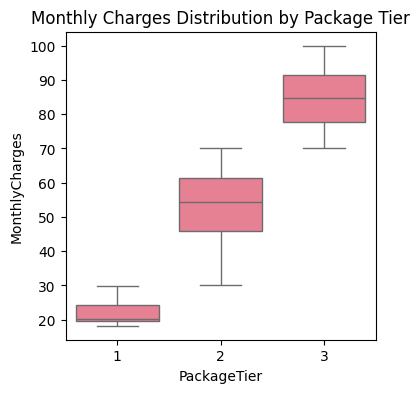

In [72]:
plt.figure(figsize=(4,4))
sns.boxplot(x='PackageTier', y='MonthlyCharges', data=df_new).set_title('Monthly Charges Distribution by Package Tier')
plt.show()

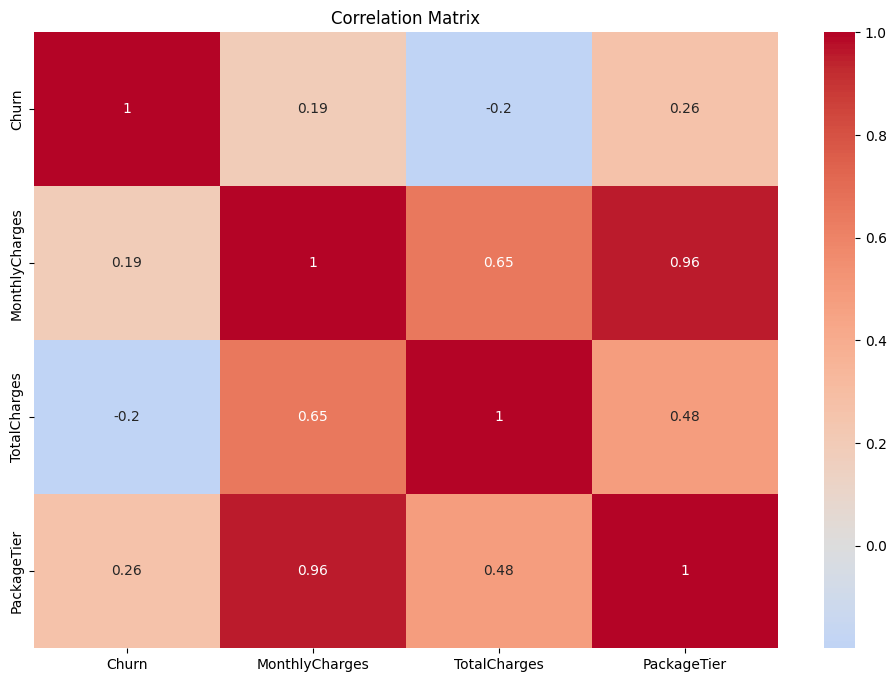

In [78]:
numerical_df = df_new[['Churn','MonthlyCharges','TotalCharges','PackageTier']]
correlation_matrix = numerical_df.corr()

plt.figure(figsize=(12,8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0).set_title('Correlation Matrix')
plt.show()